# Transform WAV files to Frequency Domain

In [1]:
import os

import torch
import torchaudio.functional
from torch.utils.data import DataLoader
import numpy as np

from src.data import WaveDataset, SpectrogramDataset
from src.features import WaveProcessor, WaveProcessorConfig
from src.visualization import plot_spectrogram, plot_waveform
import matplotlib.pyplot as plt
from tqdm import tqdm

wdir = os.getcwd().replace("\\", "/") + "/.."
processed_dir = f"{wdir}/data/processed/musicnet"
output_dir = f"{wdir}/data/output/musicnet"
print(f"Working Directory: {wdir}")
print(f"Processed Directory: {processed_dir}")

Working Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/..
Processed Directory: D:/lyx20/Documents/LiuYuxuan/universite/Year4/csc413/a2a-music-gen/notebooks/../data/processed/musicnet


## Transform WAV 2 Freq

In [3]:
sr = 44100 // 8

  0%|          | 0/7 [00:00<?, ?it/s]

1727.wav, spec: torch.Size([201, 1103])


100%|██████████| 7/7 [02:36<00:00, 22.31s/it]


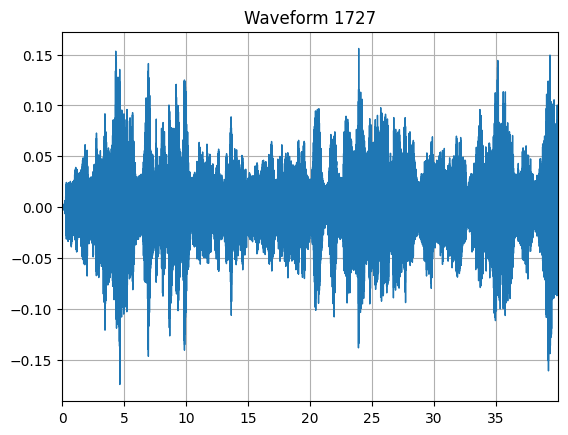

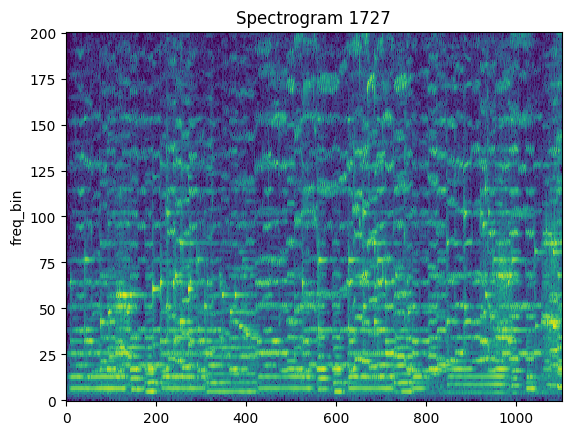

In [13]:
wav_dataset = WaveDataset(f"{wdir}/data/raw/musicnet/train_data", sr=sr, max_sec=40)
wpconfig = WaveProcessorConfig(sr=sr)
wp = WaveProcessor(wpconfig)

wav_loader = DataLoader(wav_dataset, batch_size=50, shuffle=False)
for b, (xs, fnames) in enumerate(tqdm(wav_loader)):
    # print(f"Batch {b}: x.shape={xs.shape}")
    for i, (x, fname) in enumerate(zip(xs, fnames)):
        input_spec = wp.wav2freq(x)
        
        if b % 20 == 0 and i == 0:
            print(f"{fname}.wav, spec:", input_spec.shape)
            plot_waveform(x, sr, title=f"Waveform {fname}")
            plot_spectrogram(input_spec, title=f"Spectrogram {fname}")

        SpectrogramDataset.save(input_spec, f"{processed_dir}/train_data", fname)
        SpectrogramDataset.save_metadata(
            wpconfig.to_dict(), f"{processed_dir}/train_meta", fname
        )

    # print("====================================")
    # if b == 10:
    #     break
plt.show()

## Recover Freq 2 Wave

100%|██████████| 7/7 [00:54<00:00,  7.79s/it]


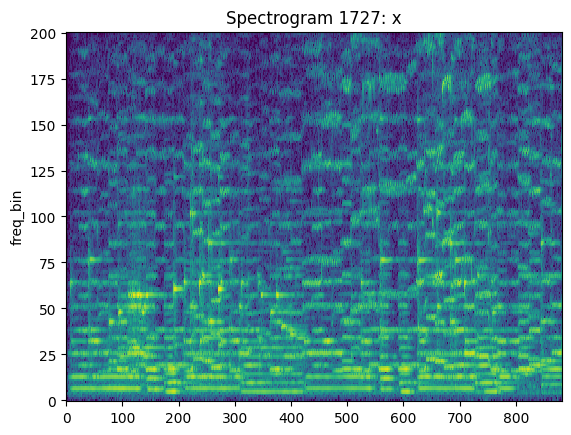

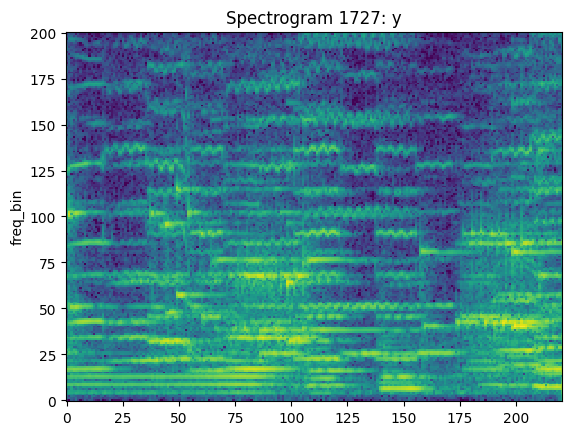

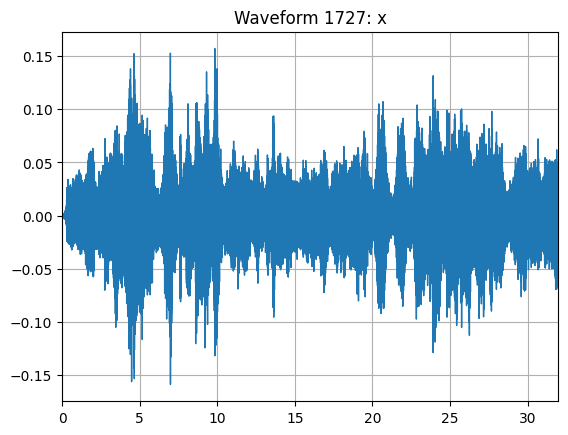

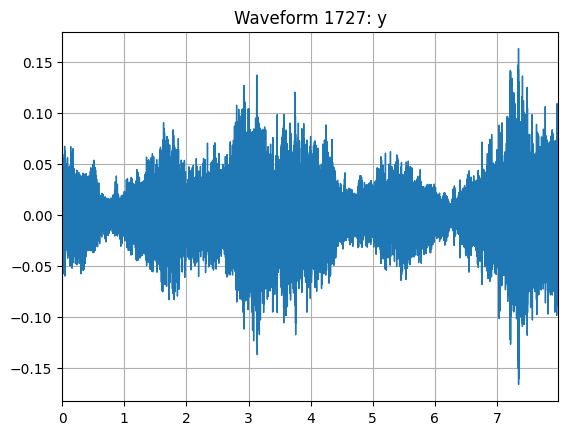

In [20]:
import torchaudio.transforms as T
spec_dataset = SpectrogramDataset(
    f"{processed_dir}/train_data"
)
spec_loader = DataLoader(spec_dataset, batch_size=50, shuffle=False)

for b, (xs, ys, fnames) in enumerate(tqdm(spec_loader)):
    # print(f"Batch {b}")
    for i, (x, y, fname) in enumerate(zip(xs, ys, fnames)):  
        # Transform back to waveform
        x_wave = wp.freq2wav(x)
        y_wave = wp.freq2wav(y)
        
        if b % 20 == 0 and i == 0:
            plot_spectrogram(x, title=f"Spectrogram {fname}: x")
            plot_spectrogram(y, title=f"Spectrogram {fname}: y")
            plot_waveform(x_wave, sr, title=f"Waveform {fname}: x")
            plot_waveform(y_wave, sr, title=f"Waveform {fname}: y")
            
        # Save to WAV file
        WaveDataset.save(x_wave, sr, f"{output_dir}/train_data", f"{fname}.x")
        WaveDataset.save(y_wave, sr, f"{output_dir}/train_data", f"{fname}.y")

    # print("====================================")
    # if b == 0:
    #     break

In [19]:
import IPython.display as ipd
ipd.Audio(f"{output_dir}/train_data/1727.x.wav")